# Machine Learning Enhanced localization in 5G networks    

# Data preparation

## Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_dataframe

# load the coverage and cir datasets

df = load_dataframe('data/5G_cov_cir_C1_interpolated_1000000.csv')

df

,latitude,longitude,PCI_cov,SSBIdx_cov,SSB_RSSI,SSS_SINR,SSS_RSRP,SSS_RSRQ,PPS,ToA_cov,operator_ID_cov,campaign_ID_cov,PCI_cir,SSBIdx_cir,ToA_cir,operator_ID_cir,campaign_ID_cir
0,41.823742,12.467466,99,0,-52.299999,10.0,-110.699997,-10.900000,2.073507,5.602907,1,1,215,1,6.32,-1,1
1,41.823742,12.467466,99,0,-52.299999,10.0,-110.699997,-10.900000,2.073507,5.602907,1,1,214,6,1.52,-1,1
2,41.823742,12.467466,99,0,-52.299999,10.0,-110.699997,-10.900000,2.073507,5.602907,1,1,215,2,0.08,-1,1
3,41.823742,12.467466,99,0,-52.299999,10.0,-110.699997,-10.900000,2.073507,5.602907,1,1,214,5,0.29,-1,1
4,41.823742,12.467466,99,0,-52.299999,10.0,-110.699997,-10.900000,2.073507,5.602907,1,1,85,1,0.47,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,41.823757,12.467394,85,6,-93.599998,-15.1,-133.399994,-26.200001,1.579707,5.108900,2,1,474,1,0.00,-1,1
999996,41.823757,12.467394,85,6,-93.599998,-15.1,-133.399994,-26.200001,1.579707,5.108900,2,1,85,3,0.00,-1,1
999997,41.823757,12.467394,85,6,-93.599998,-15.1,-133.399994,-26.200001,1.579707,5.108900,2,1,215,3,0.00,-1,1
999998,41.823757,12.467394,85,6,-93.599998,-15.1,-133.399994,-26.200001,1.579707,5.108900,2,1,215,7,0.00,-1,1


## Data splitting

In [2]:
from sklearn.model_selection import train_test_split
Y = df[['latitude', 'longitude']]

X = df.drop(['latitude', 'longitude'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

# Model building

## Linear regression

### Training the model 

In [3]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Applying model for prediction

In [4]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

### Performance evaluation

In [5]:
from utils import mean_position_error
# training data performance

lr_train_mpe = mean_position_error(y_train, y_lr_train_pred)
lr_test_mpe = mean_position_error(y_test, y_lr_test_pred)
errors_lr = pd.DataFrame([["Linear Regression", lr_train_mpe, lr_test_mpe]], columns=['Model', 'Train MPE', 'Test MPE'])

print("Performance evaluation: Linear Regression")
print("Training Mpe:", lr_train_mpe)
print("Test Mpe:", lr_test_mpe)

Performance evaluation: Linear Regression
Training Mpe: 0.6105864904423258
Test Mpe: 0.6147573360367166


## K-NN

### Training the model

In [6]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

### Applying the model for prediction

In [7]:
y_knn_train_pred = knn.predict(X_train)

y_knn_test_pred = knn.predict(X_test)

### Performance evaulation

In [8]:
knn_train_mpe = mean_position_error(y_train, y_knn_train_pred)
knn_test_mpe = mean_position_error(y_test, y_knn_test_pred)
errors_knn = pd.DataFrame([["KNN",knn_train_mpe, knn_test_mpe]], columns= ['Model','Train MPE', 'Test MPE'])

print("Performance evaluation: KNN")
print("Training Mpe:", knn_train_mpe)
print("Test Mpe:", knn_test_mpe)

Performance evaluation: KNN
Training Mpe: 0.009969805221430426
Test Mpe: 0.024199751294073604


## Random Forest

### Training the model

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

### Applying the model for prediction

In [10]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

### Performance evalutaion

In [11]:
rf_train_mpe = mean_position_error(y_train, y_rf_train_pred)
rf_test_mpe = mean_position_error(y_test, y_rf_test_pred)
errors_rf = pd.DataFrame([["Random Forest",rf_train_mpe, rf_test_mpe]], columns= ['Model','Train MPE', 'Test MPE'])

print("Performance evaluation: Random Forest")
print("Training Mpe:", rf_train_mpe)
print("Test Mpe:",rf_test_mpe)

Performance evaluation: Random Forest
Training Mpe: 0.24775773296855613
Test Mpe: 0.24864833853540086


## Model comparison

               Model  Train MPE  Test MPE
0  Linear Regression   0.610586  0.614757
0                KNN   0.009970  0.024200
0      Random Forest   0.247758  0.248648


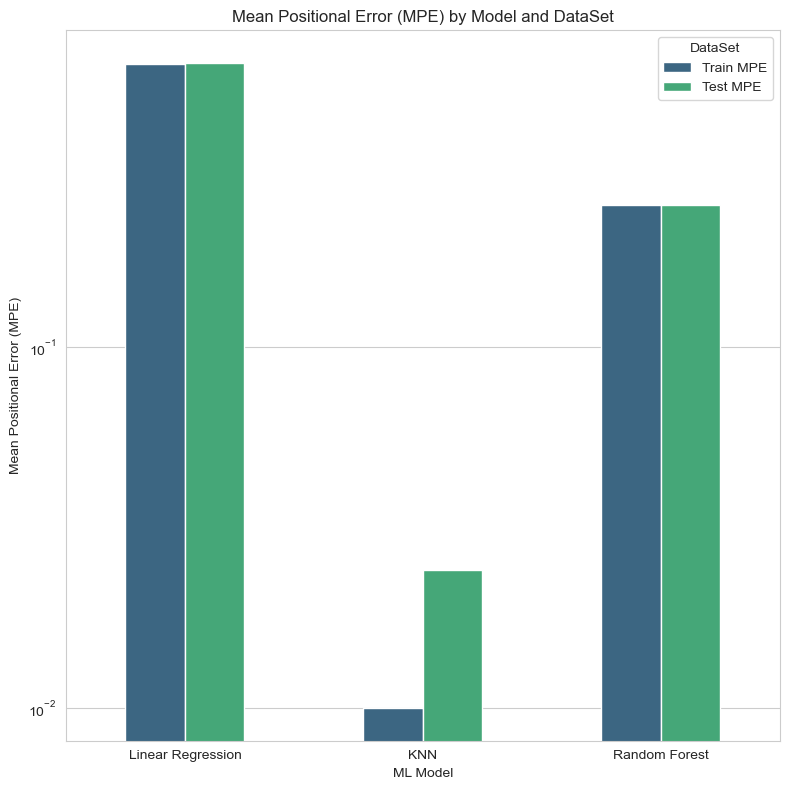

In [12]:
import seaborn as sns
errors_comp = pd.concat([errors_lr, errors_knn, errors_rf], axis=0)

print(errors_comp)

# Assuming errors_comp is already prepared
errors_comp_melted = errors_comp.melt(id_vars='Model', var_name='DataSet', value_name='MPE')

# Plot
plt.figure(figsize=(8, 8))
sns.barplot(data=errors_comp_melted, x='Model', y='MPE', hue='DataSet', palette='viridis', width=0.5)

plt.title('Mean Positional Error (MPE) by Model and DataSet')
plt.ylabel('Mean Positional Error (MPE)')
plt.xlabel('ML Model')

plt.yscale('log')  # Using a logarithmic scale to better visualize low values

plt.tight_layout()
plt.show()